# benchmark multiple google models using repetitive sums dataset and few token completion method  

We could find the token limiter parameter so we trust the models will not generate too many tokens.  
We ask for the result of a sum, and then extract the number from the output string.  

Then update the existing leaderboard for our benchmark.  

## install libs

In [1]:
%%capture
!pip install -q -U google-generativeai
!pip install datasets

## inference function  

openai models can answer from 2 to 100 using a single token.  

### define inference function  



In [28]:
import google.generativeai as genai
from google.colab import userdata
import time

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)


def extract_number(input_str):
  try:
    return int(''.join(filter(str.isdigit, input_str)))
  except ValueError:
    return 0

def get_sum_result(current_sum, curr_model):
  while True:
    try:
      model = genai.GenerativeModel(curr_model)
      messages = [
          {'role':'model', 'parts': ["You are an helpful assistant. Anser with a single token."]},
          {'role':'user', 'parts': [f"What is the result of the following sum : {current_sum} ?"]},
      ]
      response = model.generate_content(messages)

      return extract_number(response.text)
    except Exception as e: #catch possible rate limit here
      print(e)
      print("Retrying...")
      time.sleep(4)


model_name = 'gemini-1.5-flash'
curr_sum = '1+1'
get_sum_result(curr_sum, model_name)

2

### test inference function

In [23]:
test_sums = [
  '1+1',
  '2+2',
  '50+50'
]

models_to_test = [
    'gemini-1.0-pro',
    'gemini-1.5-flash',
    'gemini-1.5-pro',
]

for curr_model in models_to_test:
  print(f"--- Testing model : {curr_model} ---")
  for curr_sum in test_sums:
    llm_result = get_sum_result(curr_sum, curr_model)
    is_success = llm_result  == eval(curr_sum)
    if is_success:
      print(f"✅ {curr_sum} = {llm_result}")
    else:
      print(f"❌ {curr_sum} = {llm_result}")



--- Testing model : gemini-1.0-pro ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gemini-1.5-flash ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100
--- Testing model : gemini-1.5-pro ---
✅ 1+1 = 2
✅ 2+2 = 4
✅ 50+50 = 100


## define benchmark functions

In [24]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


## Load dataset

In [25]:
from datasets import load_dataset

dataset_ds = load_dataset("the-french-artist/repetitive_sums_benchmark", split='train')
dataset_ds

Generating train split:   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset({
    features: ['sum', 'result'],
    num_rows: 99
})

In [26]:
additions_df = dataset_ds.to_pandas()

## Perform inference on complete dataset  

In [32]:
models_to_test = [
    'gemini-1.0-pro',
    'gemini-1.5-flash',
    'gemini-1.5-pro',
]
number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...


  0%|          | 0/99 [00:00<?, ?it/s]

('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...


  0%|          | 0/99 [00:00<?, ?it/s]

('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying...


,sum,result,gemini-1.0-pro,gemini-1.5-flash,gemini-1.5-pro
0,1+1,2,2,2,2
1,1+1+1,3,3,3,3
2,1+1+1+1,4,4,4,4
3,1+1+1+1+1,5,5,5,5
4,1+1+1+1+1+1,6,6,6,6


## Analyze results

In [33]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gemini-1.0-pro,31.313131,15.725806,6.0,35.226745,1,273,6
1,gemini-1.5-flash,40.404040,15.576271,13.0,12.512343,1,42,0
2,gemini-1.5-pro,30.303030,10.289855,9.0,7.677510,1,28,0


<ipython-input-24-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


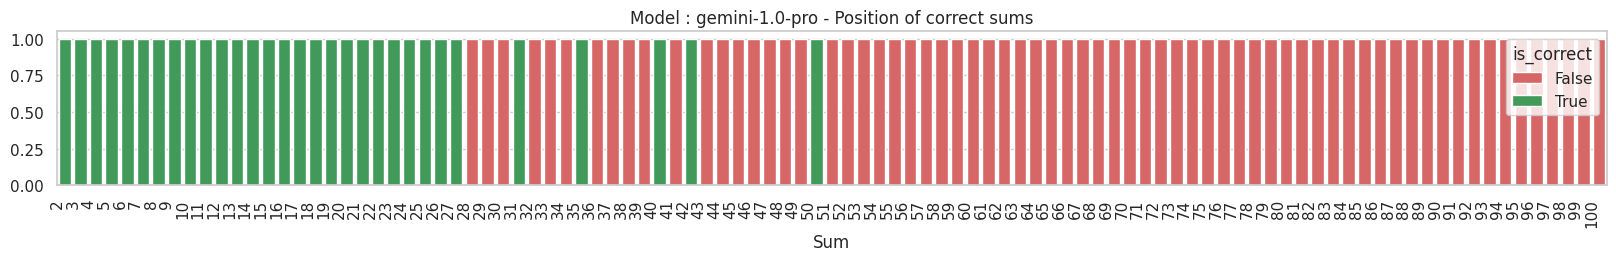

<ipython-input-24-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


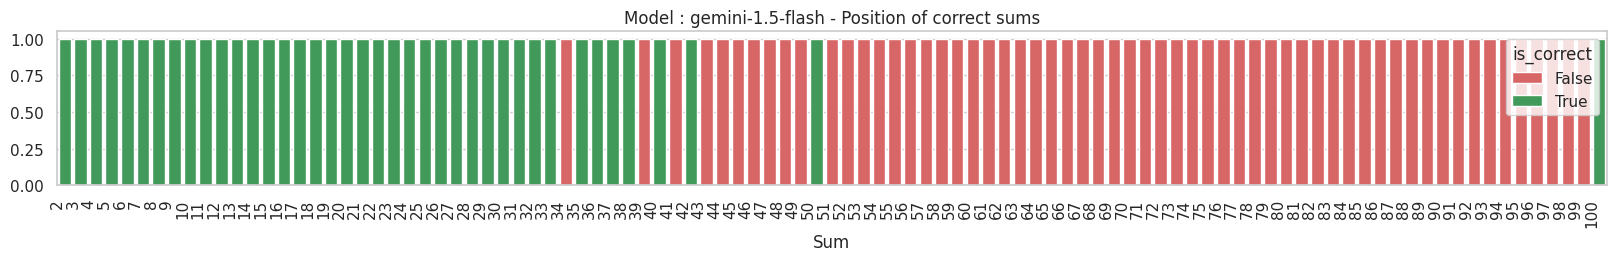

<ipython-input-24-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


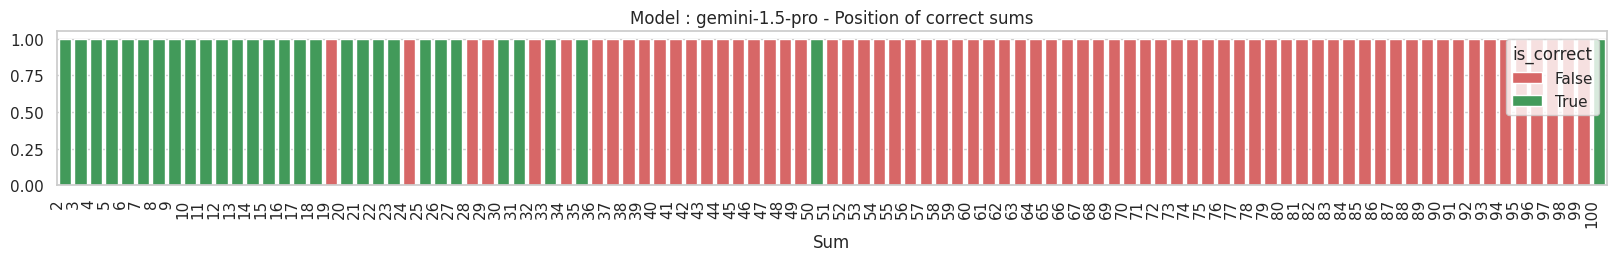

In [34]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)

## update the leaderboard

In [35]:
from datasets import load_dataset

leaderboard_ds = load_dataset('the-french-artist/repetitive_sums_benchmark_leaderboard', split='train')
leaderboard_ds

Generating train split:   0%|          | 0/27 [00:00<?, ? examples/s]

Dataset({
    features: ['model_name', 'avg_accuracy', 'error_mean', 'error_median', 'error_std', 'error_min', 'error_max', 'parsing_failure_count'],
    num_rows: 27
})

In [36]:
leaderboard_df = leaderboard_ds.to_pandas()
leaderboard_df

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-4o-2024-05-13,72.727273,3.666667,2.0,3.258126,1,12,0
1,gpt-4-0125-preview,44.444444,11.563636,9.0,9.681528,1,34,0
2,gpt-4-turbo-2024-04-09,39.393939,14.850000,10.5,12.588433,1,41,0
3,gpt-4-1106-preview,38.383838,13.868852,9.0,11.971460,1,42,0
4,gpt-4-0613,37.373737,8.483871,5.5,7.885953,1,30,0
5,mistralai/Mixtral-8x22B,34.343434,15.569231,11.0,13.677044,1,43,0
6,mistralai/Mixtral-8x22B-Instruct-v0.1,32.323232,16.059701,11.0,13.026640,1,43,0
7,Qwen/Qwen2-72B-Instruct,26.262626,23.534247,22.0,15.923500,1,54,0
8,microsoft/WizardLM-2-8x22B,26.262626,13.027397,10.0,10.825603,1,38,0
9,gpt-3.5-turbo-0125,24.242424,6.573333,6.0,5.131180,1,20,0


In [37]:
leaderboard_df_update = get_stats_recap(benchmark_df, models_to_test)
leaderboard_df_update

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gemini-1.0-pro,31.313131,15.725806,6.0,35.226745,1,273,6
1,gemini-1.5-flash,40.404040,15.576271,13.0,12.512343,1,42,0
2,gemini-1.5-pro,30.303030,10.289855,9.0,7.677510,1,28,0


In [38]:
import pandas as pd

updated_leaderboard = pd.concat([leaderboard_df, leaderboard_df_update])
updated_leaderboard = updated_leaderboard.sort_values('avg_accuracy', ascending=False)
updated_leaderboard

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gpt-4o-2024-05-13,72.727273,3.666667,2.0,3.258126,1,12,0
1,gpt-4-0125-preview,44.444444,11.563636,9.0,9.681528,1,34,0
1,gemini-1.5-flash,40.404040,15.576271,13.0,12.512343,1,42,0
2,gpt-4-turbo-2024-04-09,39.393939,14.850000,10.5,12.588433,1,41,0
3,gpt-4-1106-preview,38.383838,13.868852,9.0,11.971460,1,42,0
4,gpt-4-0613,37.373737,8.483871,5.5,7.885953,1,30,0
5,mistralai/Mixtral-8x22B,34.343434,15.569231,11.0,13.677044,1,43,0
6,mistralai/Mixtral-8x22B-Instruct-v0.1,32.323232,16.059701,11.0,13.026640,1,43,0
0,gemini-1.0-pro,31.313131,15.725806,6.0,35.226745,1,273,6
2,gemini-1.5-pro,30.303030,10.289855,9.0,7.677510,1,28,0


In [39]:
from datasets import Dataset
updated_leaderboard_ds = Dataset.from_pandas(updated_leaderboard, preserve_index=False)
updated_leaderboard_ds

Dataset({
    features: ['model_name', 'avg_accuracy', 'error_mean', 'error_median', 'error_std', 'error_min', 'error_max', 'parsing_failure_count'],
    num_rows: 30
})

In [40]:
from google.colab import userdata

updated_leaderboard_ds.push_to_hub('the-french-artist/repetitive_sums_benchmark_leaderboard', token=userdata.get('HF_TOKEN'))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/607 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/the-french-artist/repetitive_sums_benchmark_leaderboard/commit/96ea343621f58da4f6d7a76f15b1c92d9fcc369e', commit_message='Upload dataset', commit_description='', oid='96ea343621f58da4f6d7a76f15b1c92d9fcc369e', pr_url=None, pr_revision=None, pr_num=None)